<a href="https://colab.research.google.com/github/SohailaDiab/spring_2023_vail-SohailaDiab/blob/main/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

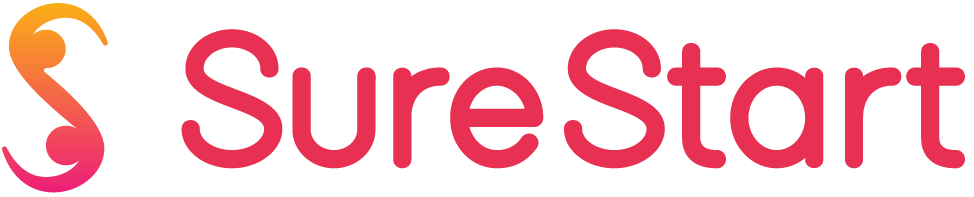

#Day 10 Objectives:
* To acquaint you with the problem of overfit models and to mitigate it with regularization

## Dependencies

### Imports

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')

# Packages for modeling
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Functions

In [2]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history
  
def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=1)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]

    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]

    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

### Loading Data

In [3]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

root = Path('../content/')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

In [4]:
! gdown --id 1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u 
! mkdir input/ 
! mv Tweets.csv input/

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u
To: /content/Tweets.csv
100% 3.42M/3.42M [00:00<00:00, 143MB/s]


In [5]:
df = pd.read_csv(input_path / 'Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]

# Remove stopwords and mentions from text
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
8131,can't wait! I'll one can't contain herself.,positive
4904,https://t.co/OQUKSo3s2O subscribe please http...,neutral
8845,thanks!,positive
1964,would never fly United Airlines again!,negative
10196,need figure scheduling out! #worstflightexper...,negative


In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

### Data Preprocessing

#### Preprocess text:

Create a matrix n*m:
- n phrases
- m unique words

Where `mat[n,m] = 1` if word appeared in phrase, else `mat[n,m] = 0`

In [7]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [8]:
X_train_oh.shape

(13176, 10000)

> We have 10,000 unique words, and 13,176 phrases

#### Preprocess labels:

Perform one-hot encoding for the 3 labels we have

In [9]:
le = LabelEncoder()

y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [10]:
y_train_oh

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### Training

In [11]:
# Split into training and validation
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

In [12]:
# Train the base model
base_model = models.Sequential()

base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))

base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)

Epoch 1/20
24/24 [==============================] - 5s 150ms/step - loss: 0.8890 - accuracy: 0.6122 - val_loss: 0.7280 - val_accuracy: 0.6608
Epoch 2/20
24/24 [==============================] - 2s 100ms/step - loss: 0.6545 - accuracy: 0.7177 - val_loss: 0.5994 - val_accuracy: 0.7496
Epoch 3/20
24/24 [==============================] - 3s 111ms/step - loss: 0.5099 - accuracy: 0.8108 - val_loss: 0.5258 - val_accuracy: 0.7944
Epoch 4/20
24/24 [==============================] - 3s 135ms/step - loss: 0.4134 - accuracy: 0.8570 - val_loss: 0.5105 - val_accuracy: 0.7944
Epoch 5/20
24/24 [==============================] - 2s 58ms/step - loss: 0.3491 - accuracy: 0.8785 - val_loss: 0.5156 - val_accuracy: 0.7974
Epoch 6/20
24/24 [==============================] - 1s 51ms/step - loss: 0.2982 - accuracy: 0.8953 - val_loss: 0.5529 - val_accuracy: 0.7921
Epoch 7/20
24/24 [==============================] - 1s 52ms/step - loss: 0.2580 - accuracy: 0.9108 - val_loss: 0.5533 - val_accuracy: 0.7891
Epoch 8/2

In [13]:
# Train the reduced model with less number of layers
reduced_model = models.Sequential()

reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))

reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

Epoch 1/20
24/24 [==============================] - 1s 43ms/step - loss: 0.9367 - accuracy: 0.6286 - val_loss: 0.8232 - val_accuracy: 0.6571
Epoch 2/20
24/24 [==============================] - 1s 33ms/step - loss: 0.7763 - accuracy: 0.6708 - val_loss: 0.7291 - val_accuracy: 0.6973
Epoch 3/20
24/24 [==============================] - 1s 32ms/step - loss: 0.6869 - accuracy: 0.7139 - val_loss: 0.6671 - val_accuracy: 0.7238
Epoch 4/20
24/24 [==============================] - 1s 29ms/step - loss: 0.6194 - accuracy: 0.7563 - val_loss: 0.6237 - val_accuracy: 0.7496
Epoch 5/20
24/24 [==============================] - 1s 30ms/step - loss: 0.5652 - accuracy: 0.7943 - val_loss: 0.5914 - val_accuracy: 0.7678
Epoch 6/20
24/24 [==============================] - 1s 29ms/step - loss: 0.5206 - accuracy: 0.8215 - val_loss: 0.5672 - val_accuracy: 0.7762
Epoch 7/20
24/24 [==============================] - 1s 33ms/step - loss: 0.4834 - accuracy: 0.8373 - val_loss: 0.5479 - val_accuracy: 0.7860
Epoch 8/20
24

# Applying regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.


> Note: A sparse model has many parameters zeroed out by regularization

In [14]:
# L2 Regularized model
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                640064    
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train regularized model
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Epoch 1/20
24/24 [==============================] - 2s 62ms/step - loss: 1.0284 - accuracy: 0.6212 - val_loss: 0.8665 - val_accuracy: 0.6783
Epoch 2/20
24/24 [==============================] - 1s 50ms/step - loss: 0.7908 - accuracy: 0.7364 - val_loss: 0.7358 - val_accuracy: 0.7656
Epoch 3/20
24/24 [==============================] - 1s 49ms/step - loss: 0.6489 - accuracy: 0.8161 - val_loss: 0.6756 - val_accuracy: 0.7815
Epoch 4/20
24/24 [==============================] - 1s 50ms/step - loss: 0.5567 - accuracy: 0.8496 - val_loss: 0.6391 - val_accuracy: 0.8005
Epoch 5/20
24/24 [==============================] - 1s 50ms/step - loss: 0.4944 - accuracy: 0.8709 - val_loss: 0.6411 - val_accuracy: 0.7891
Epoch 6/20
24/24 [==============================] - 1s 50ms/step - loss: 0.4509 - accuracy: 0.8840 - val_loss: 0.6440 - val_accuracy: 0.7929
Epoch 7/20
24/24 [==============================] - 1s 50ms/step - loss: 0.4153 - accuracy: 0.8969 - val_loss: 0.6523 - val_accuracy: 0.7898
Epoch 8/20
24

For the regularized model we notice that it starts overfitting in the same epoch as the baseline model. However, the loss increases much slower afterwards.



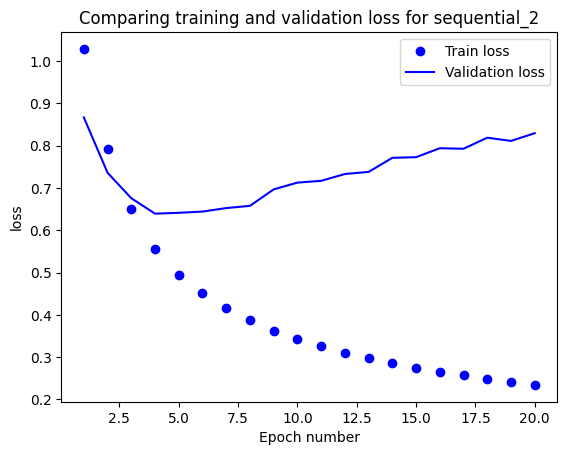

In [16]:
eval_metric(reg_model, reg_history, 'loss')

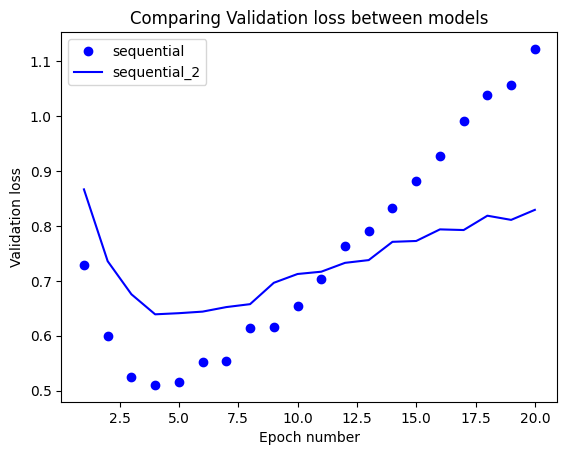

In [17]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

## Question 1

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||$$

Let's assume $w = [-5, 4, -3, 2, 1]$

In [18]:
weights = [-5, 4, -3, 2, 1]

def l1_norm(weights):
    reg = tf.reduce_sum(tf.abs(weights))
    return reg

print(l1_norm(weights))

tf.Tensor(15, shape=(), dtype=int32)


> `tf.reduce_sum`: Computes the sum of elements across dimensions of a tensor.


## Question 2

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||_2^2$$

Let's assume $w = [-5, 4, -3, 2, 1]$

In [19]:
weights = [-5, 4, -3, 2, 1]

def l2_norm(weights):
    reg = tf.reduce_sum(tf.square(weights))
    return reg

print(l2_norm(weights))

tf.Tensor(55, shape=(), dtype=int32)


## Adding dropout layers
Add dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [20]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [21]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Epoch 1/20
24/24 [==============================] - 2s 58ms/step - loss: 0.8790 - accuracy: 0.6191 - val_loss: 0.7368 - val_accuracy: 0.6358
Epoch 2/20
24/24 [==============================] - 1s 48ms/step - loss: 0.7219 - accuracy: 0.6455 - val_loss: 0.6619 - val_accuracy: 0.6980
Epoch 3/20
24/24 [==============================] - 1s 49ms/step - loss: 0.6335 - accuracy: 0.7244 - val_loss: 0.6023 - val_accuracy: 0.7663
Epoch 4/20
24/24 [==============================] - 1s 46ms/step - loss: 0.5574 - accuracy: 0.7931 - val_loss: 0.5589 - val_accuracy: 0.7898
Epoch 5/20
24/24 [==============================] - 2s 75ms/step - loss: 0.4937 - accuracy: 0.8267 - val_loss: 0.5410 - val_accuracy: 0.7959
Epoch 6/20
24/24 [==============================] - 2s 75ms/step - loss: 0.4409 - accuracy: 0.8449 - val_loss: 0.5252 - val_accuracy: 0.7989
Epoch 7/20
24/24 [==============================] - 1s 49ms/step - loss: 0.4001 - accuracy: 0.8626 - val_loss: 0.5320 - val_accuracy: 0.8020
Epoch 8/20
24

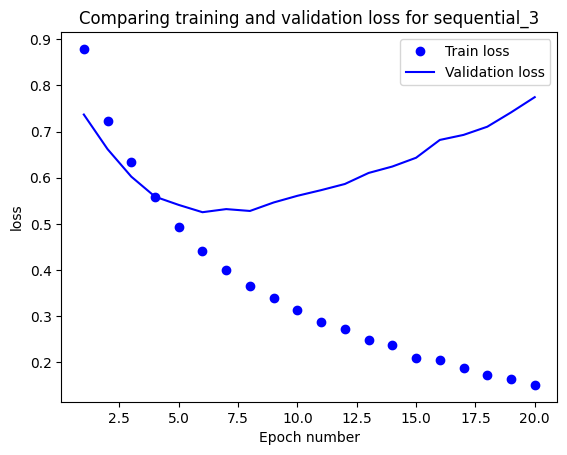

In [22]:
eval_metric(drop_model, drop_history, 'loss')

The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.



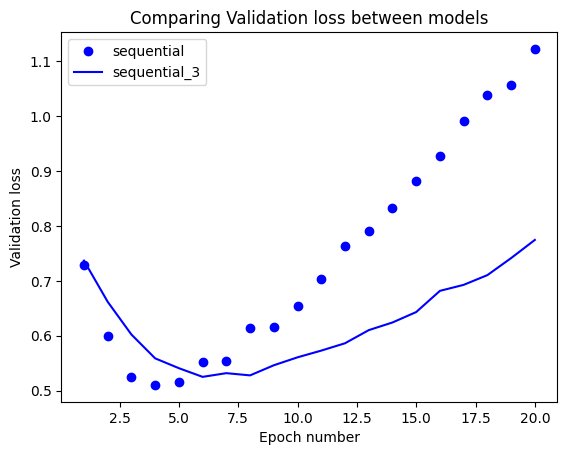

In [25]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.



## Combined L2 + dropout

In [26]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(NB_WORDS,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)
])

In [32]:
combined_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               5120512   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 512)              

In [27]:
combined_history = deep_model(combined_model, X_train_rest, y_train_rest, X_valid, y_valid)
combined_min = optimal_epoch(combined_history)

Epoch 1/20
24/24 [==============================] - 14s 534ms/step - loss: nan - accuracy: 0.6157 - val_loss: nan - val_accuracy: 0.6358
Epoch 2/20
24/24 [==============================] - 9s 388ms/step - loss: nan - accuracy: 0.6280 - val_loss: nan - val_accuracy: 0.6358
Epoch 3/20
24/24 [==============================] - 7s 300ms/step - loss: nan - accuracy: 0.6280 - val_loss: nan - val_accuracy: 0.6358
Epoch 4/20
24/24 [==============================] - 8s 350ms/step - loss: nan - accuracy: 0.6280 - val_loss: nan - val_accuracy: 0.6358
Epoch 5/20
24/24 [==============================] - 8s 316ms/step - loss: nan - accuracy: 0.6280 - val_loss: nan - val_accuracy: 0.6358
Epoch 6/20
24/24 [==============================] - 8s 339ms/step - loss: nan - accuracy: 0.6280 - val_loss: nan - val_accuracy: 0.6358
Epoch 7/20
24/24 [==============================] - 10s 414ms/step - loss: nan - accuracy: 0.6280 - val_loss: nan - val_accuracy: 0.6358
Epoch 8/20
24/24 [============================

In [31]:
combined_model

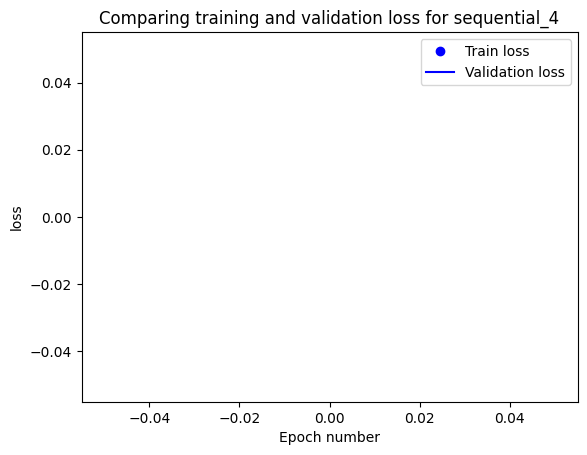

In [28]:
eval_metric(combined_model, combined_history, 'loss')

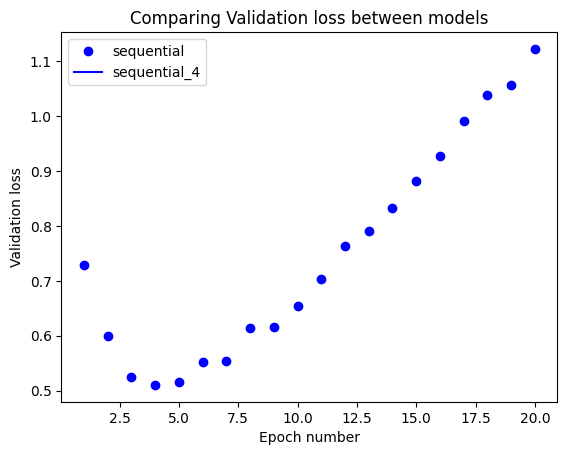

In [29]:
compare_models_by_metric(base_model, combined_model, base_history, combined_history, 'val_loss')

## Question 3

**When does it make sense to add both L2 regularization and Dropout?**

**And what did doing so achieve in this case?**

Dropout noise--or multiplicative noise from any distribution, as long as it has the right scale--should be used when one suspects there are redundant features. This is the case for most raw signals (such as pixels). A big network will have a penchant for overfitting, which in some sense means it will represent spurious patterns in its hidden units that are similar to redundant input features. Thus, Dropout is usually applied to input and hidden layers.

Assuming asymptotics kick in, Dropout is equivalent to L2 regularization scaled by the inverse Fisher information, but this is only up to a Taylor's expansion. The expansion is exact for linear models, meaning Dropout is like regularizing with R = WXT XWT (where WWT would be vanilla L2).

If no regularization does better, to paraphrase Hinton: make your net big enough that it overfits, then apply Dropout.

The number of datapoints is not enough information to know whether you need Dropout. Their dimensionality and sparsity matters. For instance, Dropout helps on MNIST, which is 50,000x784 but probably wouldn't help on a dataset of size 50,000x10.

In this case it did not uniformly help regularize the data at all.

#Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [33]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)

Epoch 1/4
26/26 [==============================] - 1s 54ms/step - loss: 0.1536 - accuracy: 0.9624
Epoch 2/4
26/26 [==============================] - 1s 46ms/step - loss: 0.1078 - accuracy: 0.9711
Epoch 3/4
26/26 [==============================] - 1s 45ms/step - loss: 0.0858 - accuracy: 0.9765
Epoch 4/4
46/46 [==============================] - 0s 3ms/step - loss: 0.9937 - accuracy: 0.7712

Test accuracy: 77.12%


In [34]:
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)

Epoch 1/13
26/26 [==============================] - 1s 45ms/step - loss: 0.2810 - accuracy: 0.9056
Epoch 2/13
26/26 [==============================] - 1s 39ms/step - loss: 0.2700 - accuracy: 0.9095
Epoch 3/13
26/26 [==============================] - 1s 29ms/step - loss: 0.2597 - accuracy: 0.9136
Epoch 4/13
26/26 [==============================] - 1s 26ms/step - loss: 0.2503 - accuracy: 0.9174
Epoch 5/13
26/26 [==============================] - 1s 26ms/step - loss: 0.2416 - accuracy: 0.9204
Epoch 6/13
26/26 [==============================] - 1s 26ms/step - loss: 0.2336 - accuracy: 0.9235
Epoch 7/13
26/26 [==============================] - 1s 26ms/step - loss: 0.2257 - accuracy: 0.9261
Epoch 8/13
26/26 [==============================] - 1s 25ms/step - loss: 0.2188 - accuracy: 0.9287
Epoch 9/13
26/26 [==============================] - 1s 28ms/step - loss: 0.2116 - accuracy: 0.9309
Epoch 10/13
26/26 [==============================] - 1s 26ms/step - loss: 0.2052 - accuracy: 0.9332
Epoch 11/

In [35]:
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)

Epoch 1/4
26/26 [==============================] - 2s 68ms/step - loss: 0.2895 - accuracy: 0.9444
Epoch 2/4
26/26 [==============================] - 2s 82ms/step - loss: 0.2589 - accuracy: 0.9557
Epoch 3/4
26/26 [==============================] - 1s 46ms/step - loss: 0.2438 - accuracy: 0.9586
Epoch 4/4
46/46 [==============================] - 0s 3ms/step - loss: 0.7875 - accuracy: 0.7787

Test accuracy: 77.87%


In [36]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

Epoch 1/6
26/26 [==============================] - 1s 47ms/step - loss: 0.2104 - accuracy: 0.9348
Epoch 2/6
26/26 [==============================] - 1s 45ms/step - loss: 0.1883 - accuracy: 0.9432
Epoch 3/6
26/26 [==============================] - 2s 79ms/step - loss: 0.1714 - accuracy: 0.9480
Epoch 4/6
26/26 [==============================] - 2s 60ms/step - loss: 0.1616 - accuracy: 0.9498
Epoch 5/6
26/26 [==============================] - 1s 47ms/step - loss: 0.1460 - accuracy: 0.9553
Epoch 6/6
46/46 [==============================] - 0s 4ms/step - loss: 0.7756 - accuracy: 0.7883

Test accuracy: 78.83%


# Handling Underfitting
* In a general situation, the best strategy is to increase the model complexity by either increasing the number of parameters of your deep learning model or the order of your model. Underfitting is due to the model being simpler than needed. It fails to capture the patterns in the data. Increasing the model complexity will lead to improvement in training performance. If we use a large enough model it can even achieve a training error of zero i.e. the model will memorize the data and suffer from over-fitting. The goal is to hit the optimal sweet spot.
* Try to train the model for more epochs. Ensure that the loss is decreasing gradually over the course of the training. Otherwise, it is highly likely that there is some kind of bug or problem in the training code/logic itself.
* If you aren’t shuffling the data after every epoch, it can harm the model performance. Ensuring that you are shuffling the data is a good check to perform at this point.

#Conclusion
To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.

here are the ways to prevent underfitting

* Get more training data.
* Increase the size or number of parameters in the model.
* Increase the complexity of the model.
* Increasing the training time, until cost function is minimised.


# Bonus content - Visualizing L2 regularization


In [37]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

In [38]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Let's create a toy data:

In [39]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

visualize the regularized **cost function** 

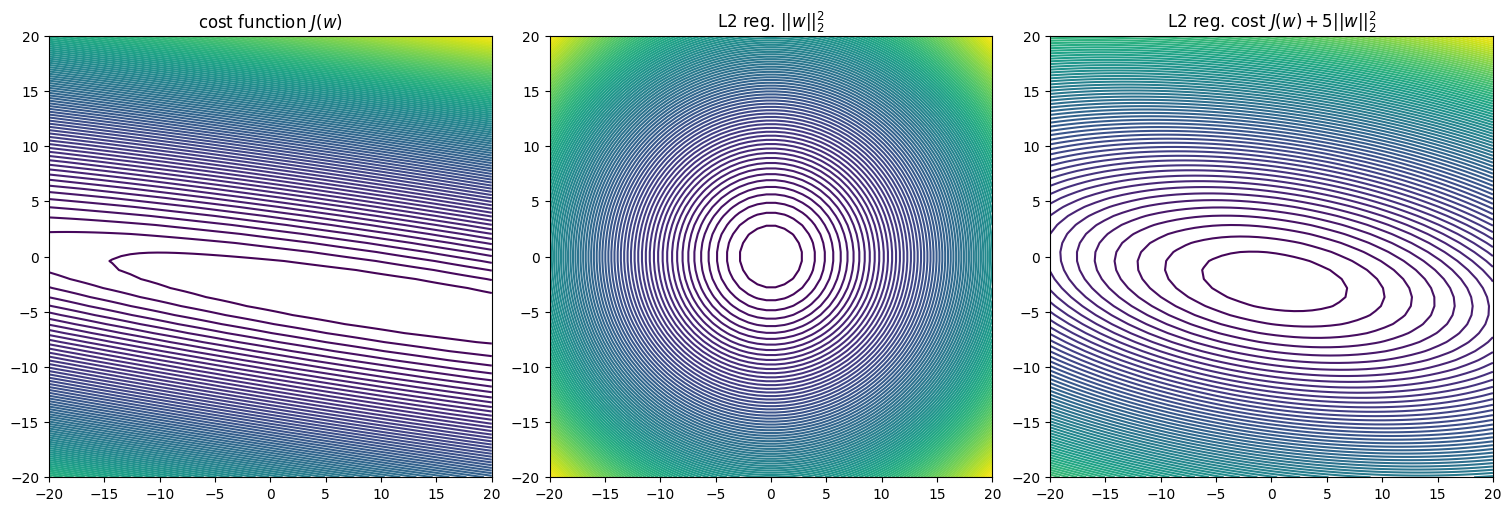

In [40]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L2 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus question: Plot the same for L1 regularization 

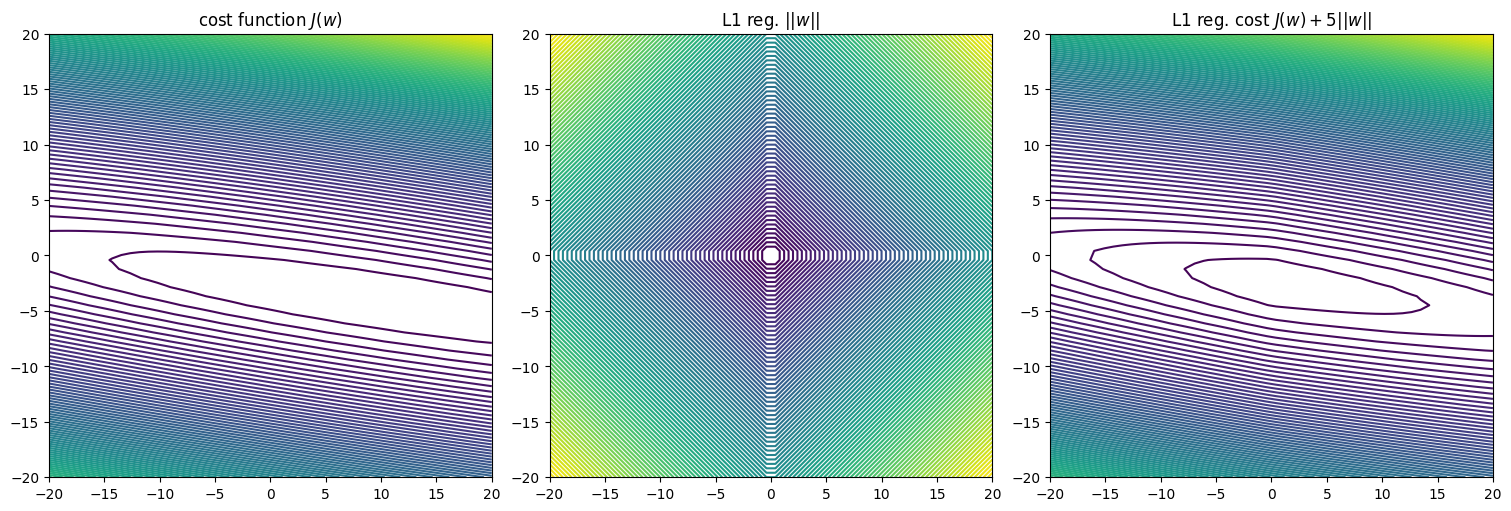

In [45]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l1_penalty = lambda w: np.sum(np.abs(w))
cost_plus_l1 = lambda w: cost(w) + 5*l1_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l1_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L1 reg. $||w||$')
plot_contour(cost_plus_l1, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L1 reg. cost $J(w) + 5 ||w||$')
plt.show()

## Bonus Question 2
**After looking at the visualization to what the L1 and L2 normalizations, how do they help while training?**

L1 and L2 regularization help in preventing overfitting during training by adding a penalty term to the loss function that encourages the model to use smaller weights.



# **Upload this Day 9 Colab Notebook to your Github repository under "Day 9" folder. Also add your *Reflection* on today's learning in README.md**